# Preparación Examen Final Procesamiento de Datos

**ENUNCIADO**

Preguntas (máximo 10 puntos posibles):
Leer los datos del fichero X (2.0 puntos)
Se proporcionaran 2 ficheros, uno con 5% de los datos y otro con 100% de los datos (gigante!!!!!)


Limpiar los datos (1.0 punto)
Reemplazar NaN por 0 si el campo es numerico y texto blanco si se trata de un texto del dataframe, utilizar para eso UDF (función de Python) y aplicarla al DataFrame de Spark.


Utilizando ambos SPARK-API y SPARK-SQL hacer EDA y contestar una pregunta (y gráficas si cabe).(2.0 puntos)
Siempre en PySpark, hacer el EDA que considerese necesario para contestar las siguientes preguntas: X, Y y Z


Desarrollar un modelo de clasificación utilizando Spark-ML para predecir especificamente la variable X = "Blah" ( o sea Logistic Regression) (3.0 puntos)

Finalmente, contestar unas preguntas teóricas . (2.0 puntos)

### Inicializacion de Spark

In [20]:
# Librerias
import pandas as pd
import findspark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext 
from pyspark.sql.session import SparkSession

In [18]:
# Spark Context y SQLContext
findspark.init()
sc = SparkContext(appName="Examen")
spark = SparkSession(sc)
sql = SQLContext(sc)

C:\Users\gonef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [17]:
# Close Spark Context
sc.stop()

NameError: name 'sc' is not defined

## 1º   LEER DATOS DEL FICHERO

### .txt

In [8]:
# SI EL FICHERO ES UN TXT
inputTxt="apache.log"
lines = sc.textFile(inputTxt)
# firstLines = sc.textFile(inputTxt).take(10) 
type(lines)
# Si hay un error al leer el fichero no saltara porque Spark es Lazy Evaluated. No habria error y no esta leyendo el fichero en verdad

pyspark.rdd.RDD

In [10]:
# Comprobacion rapida de que lo ha leido correctamente
# lines.collect() # returns a list with the whole rdd()
lines.take(3) # Es mejor porque solo traes 5 lineas a Python no el RDD completo

['in24.inetnebr.com;-;-;1995-08-01 00:00:01;GET;/shuttle/missions/sts-68/news/sts-68-mcc-05.txt;HTTP/1.0;200;1839',
 'uplherc.upl.com ;-;-;1995-08-01 00:00:07;GET;/;HTTP/1.0;304;0',
 'uplherc.upl.com;-;-;1995-08-01 00:00:08;GET;/images/ksclogo-medium.gif;HTTP/1.0;304;0']

In [ ]:
# Convertir RDD a Spark Data Frame
# in24.inetnebr.com;-;-;1995-08-01 00:00:01;GET;/shuttle/missions/sts-68/news/sts-68-mcc-05.txt;HTTP/1.0;200;1839
df_columns = ['Dominio','Valor1','Valor2','FechaHora','Peticion','Path','Protocolo','Status','NºPeticiones']
dfSparkTxt = lines.toDF(df_columns) # No funciona, deberia estar dividido en tuplas, con los distintos valores de cada columna, el rdd
dfSparkTxt.show()

### .xlsx o .csv

In [ ]:
# Si es un csv
inputCSV=""
df = spark.read.csv(inputCSV,inferSchema=True,header=True)

In [21]:
from pyspark.sql.types import *

# SI EL FICHERO ES UN EXCEL (.xlsx)
# 1º PASO: Lo leemos como data frame de pandas
# .xlsx
inputExcel="CryptoLin_Test_Examen.xlsx"
df = pd.read_excel(inputExcel)

# Leer .csv sin spark session 
# inputCSV=""
# df = pd.read_csv(inputCSV)

# 2º PASO: Definimos la estructura del Data Frame
schema = StructType([StructField("Unnamed", IntegerType(), True)
                    ,StructField("id", IntegerType(), True)
                    ,StructField("date", StringType(), True)#,StructField("date", DateType(), True)
                    ,StructField("news", StringType(), True)
                    ,StructField("final_manual_labelling", IntegerType(), True)
                    ,StructField("text_span", StringType(), True)
                    ,StructField("type_abnormal_return_fama_frech", IntegerType(), True)
                    ,StructField("Columna_NaN", FloatType(), True)
                    ,StructField("Texto_blanco", StringType(), True)
                    ])
                    
# 3º PASO: Lo convertimos de df de pandas a df de PySpark
dfSpark = sql.createDataFrame(df, schema=schema)

In [14]:
# Comprobacion de que lo ha leido correctamente
print(type(dfSpark))
print('Number of rows {}'.format(dfSpark.count()))
print('Number of columns {}'.format(len(dfSpark.columns)))
dfSpark.show(10)

<class 'pyspark.sql.dataframe.DataFrame'>
Number of rows 2683
Number of columns 9
+-------+---+---------+--------------------+----------------------+--------------------+-------------------------------+-----------+------------+
|Unnamed| id|     date|                news|final_manual_labelling|           text_span|type_abnormal_return_fama_frech|Columna_NaN|Texto_blanco|
+-------+---+---------+--------------------+----------------------+--------------------+-------------------------------+-----------+------------+
|      0|  0|1/25/2022|Ripple announces ...|                     1|{annotator1_id:6;...|                              0|       52.0|         NaN|
|      1|  1|1/25/2022|IMF directors urg...|                    -1|{annotator1_id:16...|                              0|        NaN|         NaN|
|      2|  2|1/25/2022|Dragonfly Capital...|                     1|{annotator1_id:22...|                              0|        2.0|         NaN|
|      3|  3|1/25/2022|Rick and Morty co..

## 2º LIMPIAR DATOS

Reemplazar NaN por 0 si el campo es numerico y texto blanco si se trata de un texto del dataframe, utilizar para eso UDF (función de Python) y aplicarla al DataFrame de Spark.

[PySpark When Otherwise](https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/)

In [ ]:
dfSpark.show(10)

+-------+---+---------+--------------------+----------------------+--------------------+-------------------------------+-----------+------------+
|Unnamed| id|     date|                news|final_manual_labelling|           text_span|type_abnormal_return_fama_frech|Columna_NaN|Texto_blanco|
+-------+---+---------+--------------------+----------------------+--------------------+-------------------------------+-----------+------------+
|      0|  0|1/25/2022|Ripple announces ...|                     1|{annotator1_id:6;...|                              0|       52.0|         NaN|
|      1|  1|1/25/2022|IMF directors urg...|                    -1|{annotator1_id:16...|                              0|        NaN|         NaN|
|      2|  2|1/25/2022|Dragonfly Capital...|                     1|{annotator1_id:22...|                              0|        2.0|         NaN|
|      3|  3|1/25/2022|Rick and Morty co...|                     0|{annotator1_id:15...|                              0|    

Las columnas: Columna_NaN y Texto_blanco de 'dfSpark' estan con valores NaN.
Cambiamos valor numerico NaN a 0. Y valor de String NaN a "". (También cambia null, por si acaso)

In [ ]:
from pyspark.sql.functions import when, isnan

In [15]:
def limpiarDF_Col_Numerica(df, colName, dfCol):
    dfResult = df.withColumn(colName,   when( dfCol.isNull() | isnan(dfCol), 0 )
                                        .otherwise(dfCol)) # Genera una columna llamada 'colName' comprobando la columna dfCol
    return dfResult                                        # si el valor es NaN o null guarda 0 en la nueva columna, si tiene 
                                                           # valor no lo modifica y lo guarda en la nueva columna. Si 'colName' ya existe
                                                           # sobreescribe la columna

In [16]:
def limpiarDF_Col_Str(df, colName, dfCol):
    dfResult = df.withColumn(colName,   when( dfCol.isNull() | isnan(dfCol), "" )
                                        .otherwise(dfCol))
    return dfResult

In [17]:
dfLimpio = limpiarDF_Col_Numerica(dfSpark, 'Columna_NaN', dfSpark.Columna_NaN)
dfLimpio = limpiarDF_Col_Str(dfLimpio, 'Texto_blanco', dfLimpio.Texto_blanco)

In [18]:
# Ya esta limpio el data frame
dfLimpio.show(10)

+-------+---+---------+--------------------+----------------------+--------------------+-------------------------------+-----------+------------+
|Unnamed| id|     date|                news|final_manual_labelling|           text_span|type_abnormal_return_fama_frech|Columna_NaN|Texto_blanco|
+-------+---+---------+--------------------+----------------------+--------------------+-------------------------------+-----------+------------+
|      0|  0|1/25/2022|Ripple announces ...|                     1|{annotator1_id:6;...|                              0|       52.0|            |
|      1|  1|1/25/2022|IMF directors urg...|                    -1|{annotator1_id:16...|                              0|        0.0|            |
|      2|  2|1/25/2022|Dragonfly Capital...|                     1|{annotator1_id:22...|                              0|        2.0|            |
|      3|  3|1/25/2022|Rick and Morty co...|                     0|{annotator1_id:15...|                              0|    

## 3º SPARK-API y SPARK-SQL hacer EDA

Utilizando ambos SPARK-API y SPARK-SQL hacer EDA y contestar una pregunta (y gráficas si cabe).(2.0 puntos)
Siempre en PySpark, hacer el EDA que considerese necesario para contestar las siguientes preguntas: X, Y y Z

- [Plotting Pyspark](https://standarderror.github.io/notes/Plotting-with-PySpark/#:~:text=PySpark%20doesn't%20have%20any,of%20Python's%20many%20plotting%20libraries.)

- [PySpark SQL Tutorial](https://www.datacamp.com/cheat-sheet/pyspark-cheat-sheet-spark-dataframes-in-python)

- [PySpark SQL PDF CheatSheet](http://datacamp-community-prod.s3.amazonaws.com/02213cb4-b391-4516-adcd-57243ced8eed)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

AttributeError: 'Figure' object has no attribute 'subplots_adjst'

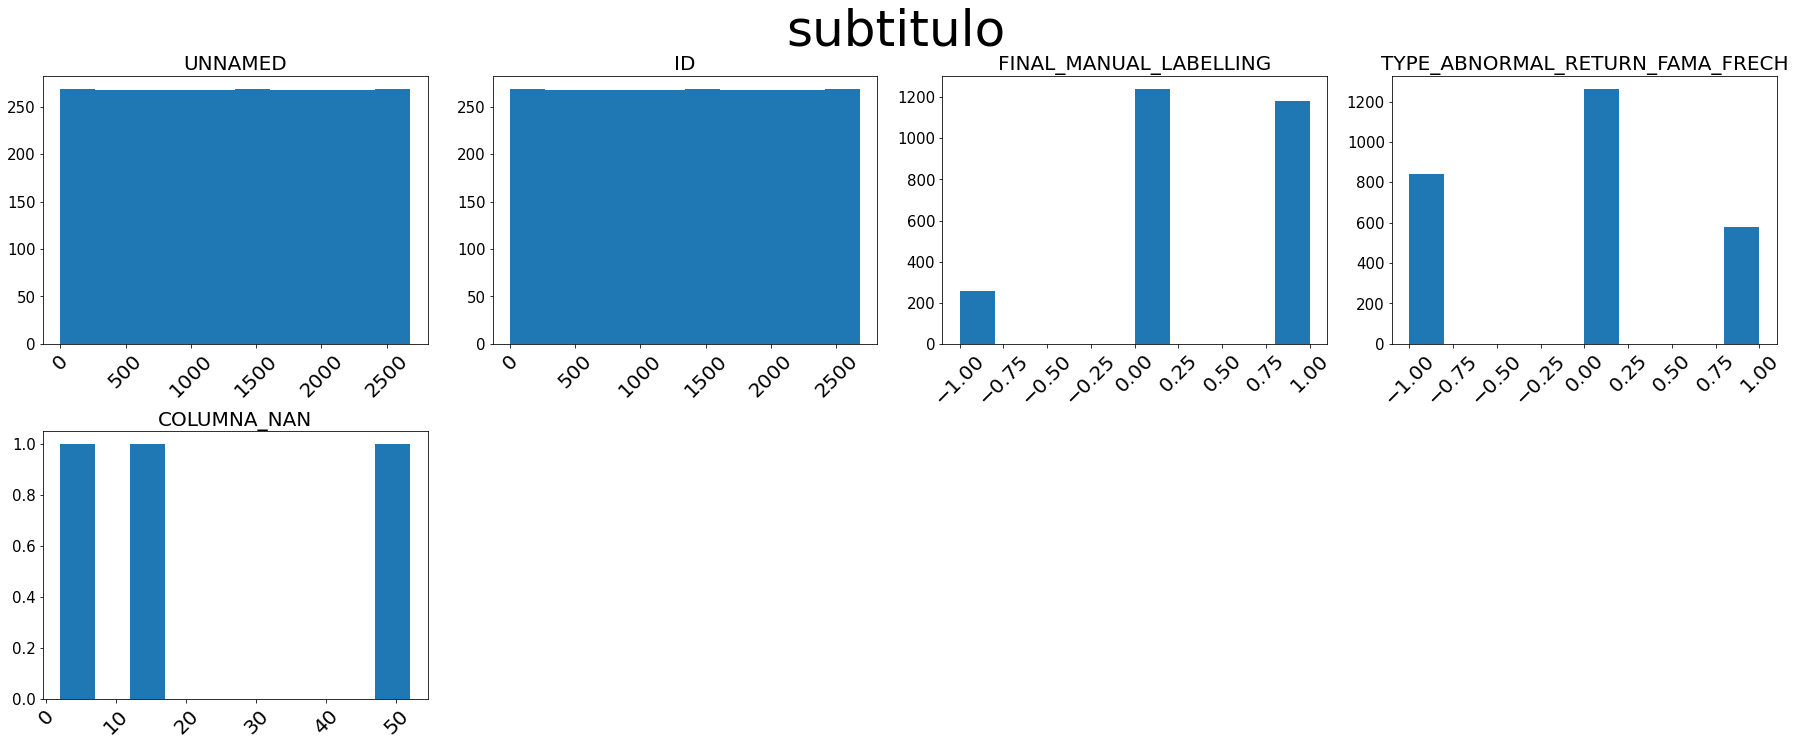

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(25,15))
st = fig.suptitle("subtitulo", fontsize=50) #verticalaligment="center")
for col, num in zip(dfSpark.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(dfSpark.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)

plt.tight_layout()
#set.set_y(0.95)
fig.subplots_adjst(top=0.85,hspace=0.4)
plt.show()

In [ ]:
# Exploratory Data Analysis, informacion de un data frame
dfSpark.describe().show()

+-------+----------------+----------------+--------+--------------------+----------------------+--------------------+-------------------------------+-----------+------------+
|summary|         Unnamed|              id|    date|                news|final_manual_labelling|           text_span|type_abnormal_return_fama_frech|Columna_NaN|Texto_blanco|
+-------+----------------+----------------+--------+--------------------+----------------------+--------------------+-------------------------------+-----------+------------+
|  count|            2683|            2683|    2683|                2683|                  2683|                2683|                           2683|       2683|        2683|
|   mean|          1341.0|          1341.0|    null|                null|   0.34513604174431606|                null|           -0.09914275065225493|        NaN|         NaN|
| stddev|774.659710238416|774.659710238416|    null|                null|    0.6469120205413876|                null|        

In [ ]:
dfSpark.groupBy('final_manual_labelling').count().show()

+----------------------+-----+
|final_manual_labelling|count|
+----------------------+-----+
|                    -1|  258|
|                     1| 1184|
|                     0| 1241|
+----------------------+-----+



In [ ]:
dfSpark.groupBy('final_manual_labelling').mean().show()

+----------------------+------------------+------------------+---------------------------+------------------------------------+----------------+
|final_manual_labelling|      avg(Unnamed)|           avg(id)|avg(final_manual_labelling)|avg(type_abnormal_return_fama_frech)|avg(Columna_NaN)|
+----------------------+------------------+------------------+---------------------------+------------------------------------+----------------+
|                    -1|1291.8062015503876|1291.8062015503876|                       -1.0|                -0.11627906976744186|             NaN|
|                     1|1358.8783783783783|1358.8783783783783|                        1.0|                -0.10810810810810811|             NaN|
|                     0|1334.1700241740532|1334.1700241740532|                        0.0|                -0.08702659145850121|             NaN|
+----------------------+------------------+------------------+---------------------------+------------------------------------+---

In [ ]:
# ACUMULADOR QUE CUENTA LINEAS EN BLANCO (Tiene muchas aplicaciones)
inputFile = "appl_with_blanks.log"
lines = sc.textFile(inputFile)
blk_cnt = sc.accumulator(0)
def Blank_lines(line):
    if(len(line) == 0):
        blk_cnt.add(1)


file = sc.textFile(inputFile)
r1 = file.foreach(lambda x: Blank_lines(x))

print("Updated Value of Accumulator: " ,blk_cnt.value)

Updated Value of Accumulator:  9


## 4º MODELO DE CLASIFICACION SPARK-ML

Desarrollar un modelo de clasificación utilizando Spark-ML para predecir especificamente la variable X = "Blah" ( o sea Logistic Regression) (3.0 puntos)

In [19]:
dfML = spark.read.csv('Teoria De Clase/Log_Reg_dataset.csv',inferSchema=True,header=True)
#check the shape of the data 
print((df.count(),len(df.columns)))

(Unnamed: 0                         2683
id                                 2683
date                               2683
news                               2683
final_manual_labelling             2683
text_span                          2683
type_abnormal_return_fama_frech    2683
Columna_NaN                           3
Texto_blanco                          3
dtype: int64, 9)


In [24]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

In [26]:
# Indexing
search_engine_class = StringIndexer(inputCol="Platform", outputCol="Platform_Num")
search_engine_obj = search_engine_class.fit(dfML)
dfML = search_engine_obj.transform(dfML)

In [27]:
dfML.show(3,False)

+-------+---+--------------+--------+----------------+------+------------+
|Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Platform_Num|
+-------+---+--------------+--------+----------------+------+------------+
|India  |41 |1             |Yahoo   |21              |1     |0.0         |
|Brazil |28 |1             |Yahoo   |5               |0     |0.0         |
|Brazil |40 |0             |Google  |3               |0     |1.0         |
+-------+---+--------------+--------+----------------+------+------------+
only showing top 3 rows



In [28]:
#one hot encoding
search_engine_encoder = OneHotEncoder(inputCol="Platform_Num", outputCol="Platform_Vector")
ohe = search_engine_encoder.fit(dfML)
dfML = ohe.transform(dfML)

In [29]:
dfML.show(3,False)

+-------+---+--------------+--------+----------------+------+------------+---------------+
|Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|Platform_Num|Platform_Vector|
+-------+---+--------------+--------+----------------+------+------------+---------------+
|India  |41 |1             |Yahoo   |21              |1     |0.0         |(2,[0],[1.0])  |
|Brazil |28 |1             |Yahoo   |5               |0     |0.0         |(2,[0],[1.0])  |
|Brazil |40 |0             |Google  |3               |0     |1.0         |(2,[1],[1.0])  |
+-------+---+--------------+--------+----------------+------+------------+---------------+
only showing top 3 rows



In [31]:
dfML.groupBy('Platform').count().orderBy('count',ascending=False).show(5,False)
dfML.groupBy('Platform_Num').count().orderBy('count',ascending=False).show(5,False)
dfML.groupBy('Platform_Vector').count().orderBy('count',ascending=False).show(5,False)


+--------+-----+
|Platform|count|
+--------+-----+
|Yahoo   |9859 |
|Google  |5781 |
|Bing    |4360 |
+--------+-----+

+------------+-----+
|Platform_Num|count|
+------------+-----+
|0.0         |9859 |
|1.0         |5781 |
|2.0         |4360 |
+------------+-----+

+---------------+-----+
|Platform_Vector|count|
+---------------+-----+
|(2,[0],[1.0])  |9859 |
|(2,[1],[1.0])  |5781 |
|(2,[],[])      |4360 |
+---------------+-----+



In [32]:
# string indexer
country_indexer = StringIndexer(inputCol="Country", outputCol="Country_Num").fit(dfML)
dfML = country_indexer.transform(dfML)

# correlacion cuando esten todas con string indexer

#one hot encoding
country_encoder = OneHotEncoder(inputCol="Country_Num", outputCol="Country_Vector")
ohe = country_encoder.fit(dfML)
dfML = ohe.transform(dfML)

In [34]:
dfML.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Platform_Num: double (nullable = false)
 |-- Platform_Vector: vector (nullable = true)
 |-- Country_Num: double (nullable = false)
 |-- Country_Vector: vector (nullable = true)



In [35]:
from pyspark.ml.feature import VectorAssembler

In [36]:
df_assembler = VectorAssembler(inputCols=['Platform_Vector','Country_Vector','Age', 'Repeat_Visitor','Web_pages_viewed'], outputCol="features")
dfML = df_assembler.transform(dfML)

In [38]:
dfML.printSchema()
dfML.select(['features','Status']).show(10,False)

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Platform_Num: double (nullable = false)
 |-- Platform_Vector: vector (nullable = true)
 |-- Country_Num: double (nullable = false)
 |-- Country_Vector: vector (nullable = true)
 |-- features: vector (nullable = true)

+-----------------------------------+------+
|features                           |Status|
+-----------------------------------+------+
|[1.0,0.0,0.0,1.0,0.0,41.0,1.0,21.0]|1     |
|[1.0,0.0,0.0,0.0,1.0,28.0,1.0,5.0] |0     |
|(8,[1,4,5,7],[1.0,1.0,40.0,3.0])   |0     |
|(8,[2,5,6,7],[1.0,31.0,1.0,15.0])  |1     |
|(8,[1,5,7],[1.0,32.0,15.0])        |1     |
|(8,[1,4,5,7],[1.0,1.0,32.0,3.0])   |0     |
|(8,[1,4,5,7],[1.0,1.0,32.0,6.0])   |0     |
|(8,[1,2,5,7],[1.0,1.0,27.0,9.0])   |0     |
|(8,[0,2,5,7],[1.0,1.0,32.0

In [39]:
#select data for building model
model_df=dfML.select(['features','Status'])

In [40]:
from pyspark.ml.classification import LogisticRegression

In [41]:
#split the data 
training_df,test_df=model_df.randomSplit([0.75,0.25])

In [42]:
(training_df.count(),test_df.count())

(15083, 4917)

In [43]:
training_df.groupBy('Status').count().show()
test_df.groupBy('Status').count().show()

+------+-----+
|Status|count|
+------+-----+
|     1| 7554|
|     0| 7529|
+------+-----+

+------+-----+
|Status|count|
+------+-----+
|     1| 2446|
|     0| 2471|
+------+-----+



In [44]:
log_reg_class=LogisticRegression(labelCol='Status')
log_reg_model=log_reg_class.fit(training_df)

In [45]:
#Training Results
train_results=log_reg_model.evaluate(training_df).predictions

C:\Users\gonef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [46]:
train_results.filter(train_results['Status']==1).filter(train_results['prediction']==1).select(['Status','prediction','probability']).show(10,False)

+------+----------+-----------------------------------------+
|Status|prediction|probability                              |
+------+----------+-----------------------------------------+
|1     |1.0       |[0.2954291998954604,0.7045708001045397]  |
|1     |1.0       |[0.2954291998954604,0.7045708001045397]  |
|1     |1.0       |[0.2954291998954604,0.7045708001045397]  |
|1     |1.0       |[0.1645514487445559,0.8354485512554441]  |
|1     |1.0       |[0.0846848768401495,0.9153151231598505]  |
|1     |1.0       |[0.0846848768401495,0.9153151231598505]  |
|1     |1.0       |[0.0846848768401495,0.9153151231598505]  |
|1     |1.0       |[0.0846848768401495,0.9153151231598505]  |
|1     |1.0       |[0.041649778130939535,0.9583502218690605]|
|1     |1.0       |[0.041649778130939535,0.9583502218690605]|
+------+----------+-----------------------------------------+
only showing top 10 rows



In [47]:
# Probability at 0 index is for 0 class and probabilty as 1 index is for 1 class
correct_preds=train_results.filter(train_results['Status']==1).filter(train_results['prediction']==1).count()

In [48]:
#accuracy on training dataset 
float(correct_preds)/(training_df.filter(training_df['Status']==1).count())

0.9379136881122584

In [49]:
# Test Set results
results=log_reg_model.evaluate(test_df).predictions

In [50]:
results.select(['Status','prediction']).show(10,False)

+------+----------+
|Status|prediction|
+------+----------+
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
|0     |0.0       |
+------+----------+
only showing top 10 rows



In [51]:
results.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Status: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [52]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [53]:
#confusion matrix
true_postives = results[(results.Status == 1) & (results.prediction == 1)].count()
true_negatives = results[(results.Status == 0) & (results.prediction == 0)].count()
false_positives = results[(results.Status == 0) & (results.prediction == 1)].count()
false_negatives = results[(results.Status == 1) & (results.prediction == 0)].count()

In [54]:
print (true_postives)
print (true_negatives)
print (false_positives)
print (false_negatives)
print(true_postives+true_negatives+false_positives+false_negatives)
print (results.count())

2304
2316
155
142
4917
4917


In [55]:
recall = float(true_postives)/(true_postives + false_negatives)
print(recall)

0.9419460343417825


In [56]:
precision = float(true_postives) / (true_postives + false_positives)
print(precision)

0.936966246441643


In [57]:
accuracy=float((true_postives+true_negatives) /(results.count()))
print(accuracy)

0.9395973154362416


# TEORIA

**pyspark.rdd.RDD**: A Resilient Distributed Dataset (RDD), the basic abstraction in Spark. Represents an immutable, partitioned collection of elements that can be operated on in parallel.

**.map()**: recorre los elementos de la lista devolviendo 1 resultado por cada elemento.

**.flatmap()**: reduce la dimension de la lista. Recorre los elementos de la lista apicando la funcion a cada elemento dentro de esa lista (Esencialmente recorre los caracteres).

In [ ]:
#import corr function from pyspark functions
from pyspark.sql.functions import corr
# check for correlation
df.select(corr('var_1','output')).show()